# Topic Clustering

1. Use an embedding model, e.g., bge-en-base-v1.5 to extract embedding vector of each event.
2. Use t-SNE to visualize the manifold of all articles.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!which python

/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/bin/python


In [3]:
import pandas as pd
from FlagEmbedding import FlagModel
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import json
from more_itertools import chunked, flatten
import faiss
from UF import UF
import numpy as np
import seaborn as sns

pd.set_option('max_colwidth', 100)

In [4]:
torch.cuda.is_available()

True

In [5]:
def create_input_text(d: dict) -> str:
    event_type = d["event_type"].lower()
    trigger = d["trigger"].lower()
    summary = d["event_summary"].lower()
    return f"Event type: {event_type}. Trigger: {trigger}. Summary: {summary}"

In [6]:
articles = json.load(open("../data/events.json"))

In [7]:
events = []
idx = 0
for article in articles:
    for event in article["events"]:
        cur_idx = idx
        event['event_id'] = cur_idx
        for dep in event['dependencies']:
            dep['event_id'] = cur_idx + dep['event_id'] - 1
        idx += 1
        events.append(event)

In [8]:
input_texts = [create_input_text(event) for event in events]

In [9]:
events_df = pd.DataFrame(events)

# Event Embedding Extraction

In [10]:
bge = FlagModel("BAAI/bge-base-en-v1.5", use_fp16=True)
bge.model.to("cuda")
# bge.device = torch.device("cpu")


----------using 10*GPUs----------


DataParallel(
  (module): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [11]:
embeddings = bge.encode(input_texts)
#embeddings = [encode(chunk) for chunk in tqdm(list(chunked(articles, 10)))]

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.09it/s]


In [12]:
events_df['bge_embedding'] = embeddings.tolist()

In [13]:
events_df.to_parquet("../data/emb_output.parquet", engine="pyarrow")

# Event Clustering

In [14]:
events_df['event_id'] = np.arange(len(events_df))

In [15]:
D = 768
K = 768//2
index = faiss.IndexPQ(D, K, 8)

In [16]:
index.train(embeddings)
index.add(embeddings)

In [17]:
TOP_K = 100
distance_matrix, index_matrix = index.search(np.array(embeddings), TOP_K)

In [18]:
THRESHOLD = 0.1
N = len(events_df)
uf = UF(N)
events_df['cluster_id'] = events_df['event_id']
for cur_i, (distances, indexes) in tqdm(enumerate(zip(distance_matrix, index_matrix))):
    for d, i in zip(distances, indexes):
        if d >= THRESHOLD: break
        uf.union(events_df.iloc[cur_i].event_id, events_df.iloc[i].event_id) 

0it [00:00, ?it/s]

In [19]:
# reassign cluster_id
events_df['cluster_id'] = events_df['cluster_id'].apply(uf.find)

In [20]:
events_df['cluster_id'].value_counts()

cluster_id
272      155
23168     73
33954     40
25670     26
21870     25
        ... 
11731      1
11730      1
11729      1
11728      1
11744      1
Name: count, Length: 31996, dtype: int64

In [21]:
def plot_2d(events_df, perplexity=5):
   tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)  # Adjust perplexity based on your dataset
   embeddings = np.array(events_df['bge_embedding'].tolist())
   embeddings_2d = tsne.fit_transform(embeddings)
   events_df.loc[:, 'x'] = embeddings_2d[:, 0]
   events_df.loc[:, 'y'] = embeddings_2d[:, 1]
   sns.scatterplot(events_df, x='x', y='y', hue='cluster_id', s=10, palette="deep")

In [22]:
top_clusters = events_df['cluster_id'].value_counts().head(10).index
top_events = events_df[events_df.cluster_id.isin(top_clusters)]

/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2082207/4258725280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df.loc[:, 'x'] = embeddings_2d[:, 0]
/tmp/ipykernel_2082207/4258725280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

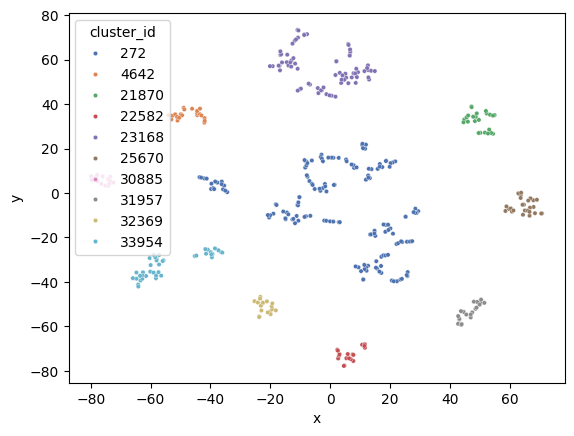

In [23]:
plot_2d(top_events)

In [24]:
events_df.drop(columns=['bge_embedding']).to_parquet("../data/cluster_output.parquet", engine="pyarrow")